mesh size:  393660
Active cells created from topography!
# of data:  961
covariances_: [[[1.25e-07]]

 [[5.00e-07]]]


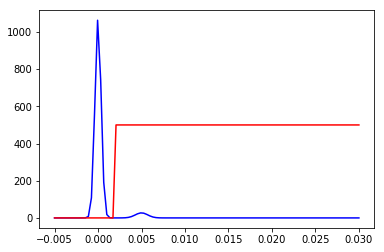

In [1]:
"""
Script of inversion of magnetics over TKC
"""

import SimPEG.PF as PF
from SimPEG import *
from SimPEG.Utils import io_utils
import matplotlib
import time as tm
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import NearestNDInterpolator
from sklearn.mixture import GaussianMixture
import numpy as np
import copy
from pymatsolver import PardisoSolver

matplotlib.rcParams['font.size'] = 14
%matplotlib inline
# Reproducible Science
np.random.seed(518936)

# We first need to create a susceptibility model.
# Based on a set of parametric surfaces representing TKC,
# we use VTK to discretize the 3-D space.

mesh = Mesh.load_mesh('C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/mesh_inverse')
print('mesh size: ', mesh.nC)
# Define no-data-value
ndv = -100

# Define survey flight height
Z_bird = 20.

# Load topography file in UBC format and find the active cells
# Import Topo
model_dir = 'C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Geological_model/'
topofile = model_dir + 'TKCtopo.dat'
topo = np.genfromtxt(topofile, skip_header=1)
# Find the active cells
actv = Utils.surface2ind_topo(mesh, topo, gridLoc='N')
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, ndv)
print("Active cells created from topography!")

# Load data
survey, _ = io_utils.readUBCmagneticsObservations(
    "C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/MAG_CoarseForward_Synthetic_data_noisy.obs"
)
print('# of data: ', survey.nD)
# Now that we have a survey we can build the linear system ...
nactv = np.int(np.sum(actv))
# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=nactv)
# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(
    mesh, chiMap=idenMap,
    actInd=actv,
    Solver=PardisoSolver
)
# Pair the survey and problem
survey.pair(prob)

G = np.load('C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/G_Mag_Inverse.npy')
prob._G = G


# We add some random Gaussian noise
std = 1.
#survey.dobs += std * np.random.randn(len(survey.dobs))
survey.eps = 0.

# **Inverse problem**

# Petro Inversion

# It is potential fields, so we will need to push the inverison down
# Create distance weights from our linera forward operator
# rxLoc = survey.srcField.rxList[0].locs
# wr = PF.Magnetics.get_dist_wgt(mesh, rxLoc, actv, 3., np.min(mesh.hx)/4.)
# wr = wr**2.
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr / np.max(wr))

m0 = np.ones(idenMap.nP) * 1e-4

# Define Petrophysics
mesh_forward = Mesh.load_mesh('C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/mesh_forward')
model_mag = mesh_forward.readModelUBC(
    'C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/Synthetic_Mag_forward.sus'
)
geomodel = mesh.readModelUBC(
    'C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/geomodel_inverse_reduced'
)
model_mag = model_mag[model_mag != -100.]
n = 2
means_init = np.array([0., 0.005]).reshape(n, 1)
# cov_init = np.array(
#     [[1e-7],
#      [2.*(1. * 0.5 * 1e-3)**2.],
#      [2.*(1. * 0.5 * 1e-3)**2.]]).reshape((3, 1, 1))
cov_init = np.array([[[1.25e-7]],[[5.00e-07]],])
weights_init = np.r_[
    np.count_nonzero(geomodel == 0.),
    np.count_nonzero(geomodel == 1.)+ np.count_nonzero(geomodel == 2.),
]/len(geomodel[geomodel!=-100.])
# cov_init = np.array([[(1. * 1e-2)**2.]])
# samples = copy.deepcopy(m_true[actv])
# samples[samples == -.4] = np.ones_like(samples)[samples == -.4] * (-0.1)
meshweights = copy.deepcopy(mesh)
meshweights._vol = meshweights.vol[actv]
clf = Utils.WeightedGaussianMixture(
    mesh = meshweights,
    n_components=n,
    covariance_type='full',
    reg_covar=1e-7,
    means_init=means_init,
    precisions_init=np.linalg.inv(cov_init),
    n_init=1,
    max_iter=100,
    tol=1e-3,
    init_params='random'
)
clf.fit(m0.reshape(-1, 1))
Utils.order_clusters_GM_weight(clf)
clf.weights_ = weights_init
clf.means_ = means_init
clf.covariances_ = cov_init
clf.precisions_cholesky_ = Utils._compute_precision_cholesky(
    clf.covariances_, clf.covariance_type
)
Utils.computePrecision(clf)
Utils.order_clusters_GM_weight(clf)
print('covariances_:', clf.covariances_)
vmin, vmax = -0.005, 0.03
plt.plot(
     np.linspace(vmin, vmax, 100), np.exp(
         clf.score_samples(np.linspace(vmin, vmax, 100)[:, np.newaxis])
     ),
     color='blue'
)
plt.plot(
     np.linspace(vmin, vmax, 100), (
         500.*clf.predict(np.linspace(vmin, vmax, 100)[:, np.newaxis])
     ),
     color='red'
)
plt.show()
wires = Maps.Wires(('m', m0.shape[0]))
reg = Regularization.MakeSimplePetroRegularization(
    GMmref=clf,
    GMmodel=clf,
    mesh=mesh,
    wiresmap=wires,
    maplist=[idenMap],
    mref=m0,
    indActive=actv,
    alpha_s=1.0, alpha_x=1.0, alpha_y=1.0, alpha_z=1.0,
    alpha_xx=0., alpha_yy=0., alpha_zz=0.,
    cell_weights_list=[wr]
)
dmis = DataMisfit.l2_DataMisfit(survey)
# Assign flat uncertainties of 0.1mGal
wd = np.ones(len(survey.dobs)) * std
dmis.W = 1 / wd

reg.mrefInSmooth = False
reg.approx_gradient = True
reg.objfcts[0].evaltype = 'approx'
gamma_petro = 1e8*np.ones(n)
reg.objfcts[0].gamma = gamma_petro

# Add directives to the inversion
# opt = Optimization.InexactGaussNewton(maxIter=30)
opt = Optimization.ProjectedGNCG(
    maxIter=30, lower=0., upper=1., maxIterLS=20, maxIterCG=100, tolCG=1e-3
)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

Alphas = Directives.AlphasSmoothEstimate_ByEig(
    alpha0_ratio=0.5,
    ninit=10, verbose=True
)
beta = Directives.BetaEstimate_ByEig(beta0_ratio=1., ninit=10)
betaIt = Directives.PetroBetaReWeighting(
    verbose=True, rateCooling=5., rateWarming=1.,
    tolerance=0.1, UpdateRate=1,
    ratio_in_cooling=False,
    progress=0.2,
    update_prior_confidence=False,
    progress_gamma_cooling=1.,
    ratio_in_gamma_cooling=False,
    alphadir_rateCooling=1.,
    kappa_rateCooling=1.,
    nu_rateCooling=1.,
)
targets = Directives.PetroTargetMisfit(verbose=True)
MrefInSmooth = Directives.AddMrefInSmooth(
    wait_till_stable=False,
    verbose=True
)
petrodir = Directives.GaussianMixtureUpdateModel(
    keep_ref_fixed_in_Smooth=True,
    verbose=False,
    nu=1e8,
    kappa=1e8,
    alphadir=1e8
)
update_Jacobi = Directives.UpdatePreconditioner()

inv = Inversion.BaseInversion(
    invProb,
    directiveList=[
        Alphas, beta,
        petrodir, targets,
        betaIt, MrefInSmooth, update_Jacobi
    ]
)


In [2]:
weights_init

array([0.95174488, 0.04825512])

In [3]:
m0 = np.ones(idenMap.nP) * 1e-4

# Run inversion...
mcluster = inv.run(m0)




                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
Alpha scales:  [1, 1]
Alpha scales:  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Alpha scales:  [0.0, 8039698.545065636, 8003531.586735962, 9302623.767680343]
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.51e+00  6.31e+05  0.00e+00  6.31e+05    5.08e+02      0              
DM:  [49137.69814021] [False] ; CL:  924941.1094016478 False ; DP:  True ; All: False
progress [49137.69814021] >< [504502.46232687]
mref changes in  49490  places
   1  1.51e+00  4.91e+04  1.38e+04  6.99e+04    3.17e+02      0              
DM:  [10141.0989821] [False] ; CL:  211196.435501

In [4]:
# Get the final model back to full space
m_petro = actvMap * mcluster
m_petro[m_petro == ndv] = np.nan
# Save both models to file
Mesh.TensorMesh.writeModelUBC(
    mesh,
    'SimPEG_MAG_petro_Inversion_crime_onlyPK_lesscovariance2_forceAddmref.sus',
    m_petro
)

import pickle
pickle.dump(reg.objfcts[0].GMmodel, open(
    "clfinv_MAG_petro_Inversion_crime_onlyPK_lesscovariance2_forceAddmref.p", "wb"))


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


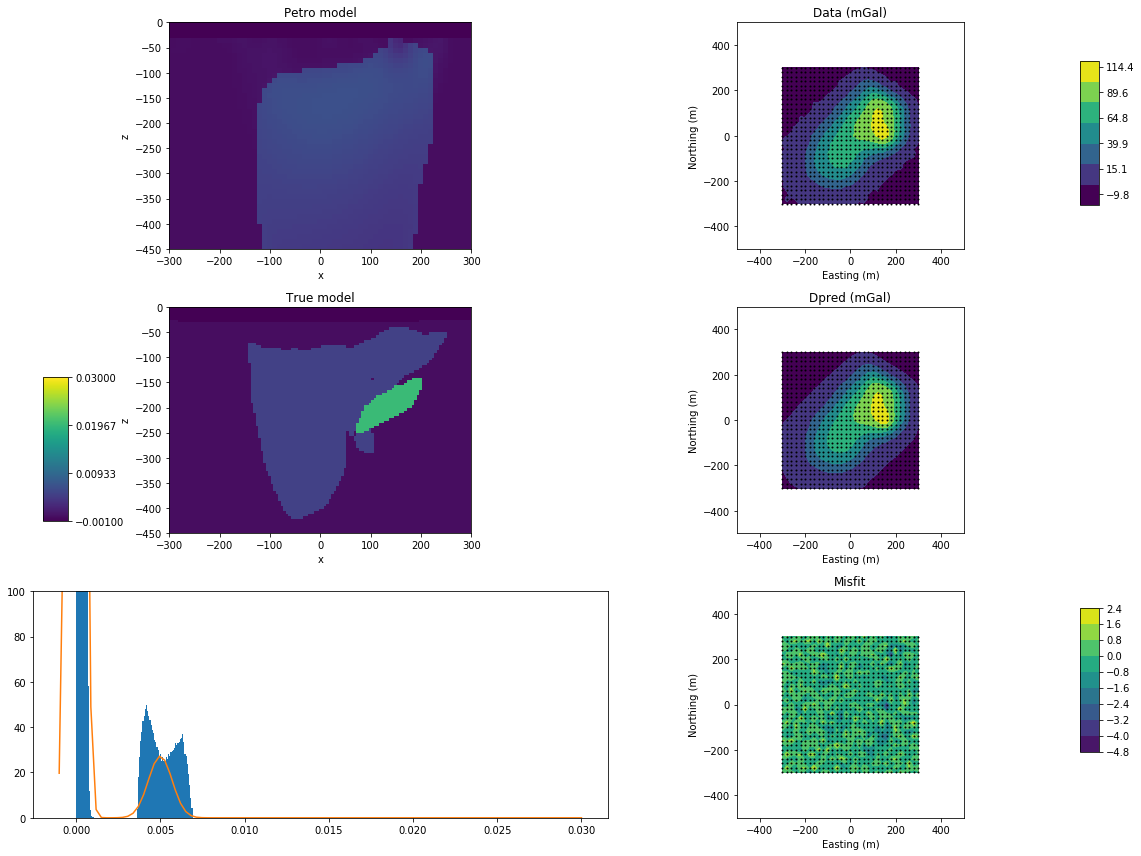

In [5]:

# Plot the recoverd models
mesh = Mesh.TensorMesh([mesh.hx, mesh.hy, mesh.hz], x0="CCN")
npad = 10
X, Y = np.meshgrid(mesh.vectorCCx[npad:-npad:2], mesh.vectorCCy[npad:-npad:2])

vmin, vmax = -1e-3, 3e-2
fig, ax = plt.subplots(3, 2, figsize=(16, 12))
ax = Utils.mkvc(ax)
mesh.plotSlice(
    actvMap * mcluster, ax=ax[0], normal='Y',
    clim=np.r_[vmin, vmax]
)
ax[0].set_aspect('equal')
ax[0].set_title('Petro model')
ax[0].set_xlim([-300, 300])
ax[0].set_ylim([-450, 0])


mesh_forward = Mesh.load_mesh('C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/mesh_forward')
mesh_forward = Mesh.TensorMesh(
    [mesh_forward.hx, mesh_forward.hy, mesh_forward.hz],
    x0="CCN"
)
model_mag = mesh_forward.readModelUBC(
    'C:/Users/Thibaut Astic/Dropbox/PhD_UBC/TKC_Joint_SEG_abstract_example/Forward and Operators/Synthetic_Mag_forward.sus'
)
dat_true = mesh_forward.plotSlice(
    model_mag, ax=ax[1], normal='Y',
    clim=np.r_[vmin, vmax]
)

ax[1].set_aspect('equal')
ax[1].set_title('True model')
ax[1].set_xlim([-300, 300])
ax[1].set_ylim([-450, 0])

pos = ax[1].get_position()
cbarax = fig.add_axes(
    [pos.x0 - 0.15, pos.y0,  pos.width * 0.1, pos.height * 0.75]
)  # the parameters are the specified position you set
cb = fig.colorbar(
    dat_true[0], cax=cbarax, orientation="vertical",
    ax=ax[1], ticks=np.linspace(vmin, vmax, 4)
)

ax[2].hist(mcluster, bins=100, density=True)
ax[2].plot(
    np.linspace(vmin, vmax, 100), np.exp(
        clf.score_samples(np.linspace(vmin, vmax, 100)[:, np.newaxis])
    )
)
ax[2].set_ylim([0., 100.])

gmin, gmax = np.min(survey.dobs), np.max(survey.dobs)
d2D = survey.dobs.reshape(X.shape)
dat = ax[3].contourf(X, Y, d2D, vmin=gmin, vmax=gmax)
ax[3].set_aspect('equal')
ax[3].plot(X.flatten(), Y.flatten(), 'k.', ms=2)
ax[3].set_xlabel("Easting (m)")
ax[3].set_ylabel("Northing (m)")
ax[3].set_title("Data (mGal)")
ax[3].set_xlim(-500, 500)
ax[3].set_ylim(-500, 500)

pos = ax[3].get_position()
cbarax = fig.add_axes(
    [pos.x0 + 0.3, pos.y0 + 0.1,  pos.width * 0.1, pos.height * 0.75]
)  # the parameters are the specified position you set
cb = fig.colorbar(
    dat, cax=cbarax, orientation="vertical",
    ax=ax[3], ticks=np.linspace(gmin, gmax, 6)
)

dpred = prob.fields(mcluster)
d2D = dpred.reshape(X.shape)
dat = ax[4].contourf(X, Y, d2D, vmin=gmin, vmax=gmax)
ax[4].set_aspect('equal')
ax[4].plot(X.flatten(), Y.flatten(), 'k.', ms=2)
ax[4].set_xlabel("Easting (m)")
ax[4].set_ylabel("Northing (m)")
ax[4].set_title("Dpred (mGal)")
ax[4].set_xlim(-500, 500)
ax[4].set_ylim(-500, 500)

# pos = ax[4].get_position()
# cbarax = fig.add_axes(
#     [pos.x0+0.3 , pos.y0,  pos.width*0.1, pos.height*0.75]
# )  # the parameters are the specified position you set
# cb = fig.colorbar(
#     dat,cax=cbarax, orientation="vertical",
#     ax=ax[4],ticks=np.linspace(gmin,gmax, 6)
# )

misfit = (survey.dobs - dpred) * dmis.W.diagonal()
d2D = misfit.reshape(X.shape)
dat = ax[5].contourf(X, Y, d2D)
ax[5].set_aspect('equal')
ax[5].plot(X.flatten(), Y.flatten(), 'k.', ms=2)
ax[5].set_xlabel("Easting (m)")
ax[5].set_ylabel("Northing (m)")
ax[5].set_title("Misfit")
ax[5].set_xlim(-500, 500)
ax[5].set_ylim(-500, 500)

pos = ax[5].get_position()
cbarax = fig.add_axes(
    [pos.x0 + 0.3, pos.y0,  pos.width * 0.1, pos.height * 0.75]
)  # the parameters are the specified position you set
cb = fig.colorbar(
    dat, cax=cbarax, orientation="vertical",
    ax=ax[5],
)
plt.tight_layout()
#fig.savefig('PF_AllUnits_with_jacobi_1nTuncert.png', dpi=150)
plt.show()


In [6]:
invProb.reg.objfcts[0].GMmodel.means_

array([[1.20516388e-12],
       [5.00000000e-03]])